In [28]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ 库导入成功")

✓ 库导入成功


In [29]:
# 加载数据
print("正在加载数据...")

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

print(f"✓ 训练集: {len(X_train)} samples")
print(f"✓ 测试集: {len(X_test)} samples")

# 查看数据
print("\nX_train前几行:")
print(X_train.head())

正在加载数据...
✓ 训练集: 6775 samples
✓ 测试集: 1694 samples

X_train前几行:
                                       combined_text  subject_length  \
0  account access im having an issue with the pro...              14   
1  delivery problem ive accidentally deleted impo...              16   
2  cancellation request there seems to be a hardw...              20   
3  network problem im having an issue with the pr...              15   
4  battery life im having an issue with the produ...              12   

   description_length  combined_length  subject_word_count  \
0                 284              299                   2   
1                 292              309                   2   
2                 264              285                   2   
3                 244              260                   2   
4                 331              344                   2   

   description_word_count  combined_word_count  ticket_type_frequency  \
0                      55                   57            

In [30]:
# ============================================
# TF-IDF Vectorization
# ============================================

print("正在进行TF-IDF特征提取...\n")

# 创建TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,      # 最多5000个特征（够用了）
    min_df=2,               # 至少出现在2个文档中
    max_df=0.8,             # 最多出现在80%的文档中
    ngram_range=(1, 2)      # 使用1-gram和2-gram
)

# 提取训练集的combined_text
X_train_text = X_train['combined_text']
X_test_text = X_test['combined_text']

# 转换为TF-IDF特征
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f"✓ TF-IDF特征提取完成")
print(f"特征矩阵大小: {X_train_tfidf.shape}")
print(f"词汇表大小: {len(vectorizer.vocabulary_)}")

# 提取y的值（从DataFrame变成array）
y_train_values = y_train.values.ravel()
y_test_values = y_test.values.ravel()

正在进行TF-IDF特征提取...

✓ TF-IDF特征提取完成
特征矩阵大小: (6775, 5000)
词汇表大小: 5000


In [31]:
# ============================================
# 训练Logistic Regression
# ============================================

print("正在训练Logistic Regression模型...\n")

# 创建模型
model = LogisticRegression(
    max_iter=1000,           # 最大迭代次数
    random_state=42,         # 保证可重复
    multi_class='multinomial',  # 多分类
    solver='lbfgs'           # 求解器
)

# 训练模型
model.fit(X_train_tfidf, y_train_values)

print("✓ 模型训练完成")

# 在训练集上的准确率
train_accuracy = model.score(X_train_tfidf, y_train_values)
print(f"训练集准确率: {train_accuracy:.4f}")

正在训练Logistic Regression模型...



/Users/shiyuwang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ 模型训练完成
训练集准确率: 0.5863


In [32]:
# ============================================
# 预测
# ============================================

print("正在进行预测...\n")

# 预测测试集
y_pred = model.predict(X_test_tfidf)

# 计算准确率
test_accuracy = accuracy_score(y_test_values, y_pred)

print(f"测试集准确率: {test_accuracy:.4f}")
print(f"\n详细分类报告:\n")
print(classification_report(y_test_values, y_pred))

正在进行预测...

测试集准确率: 0.2544

详细分类报告:

              precision    recall  f1-score   support

    Critical       0.25      0.25      0.25       426
        High       0.25      0.23      0.24       417
         Low       0.26      0.25      0.26       413
      Medium       0.26      0.28      0.27       438

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.25      0.25      0.25      1694



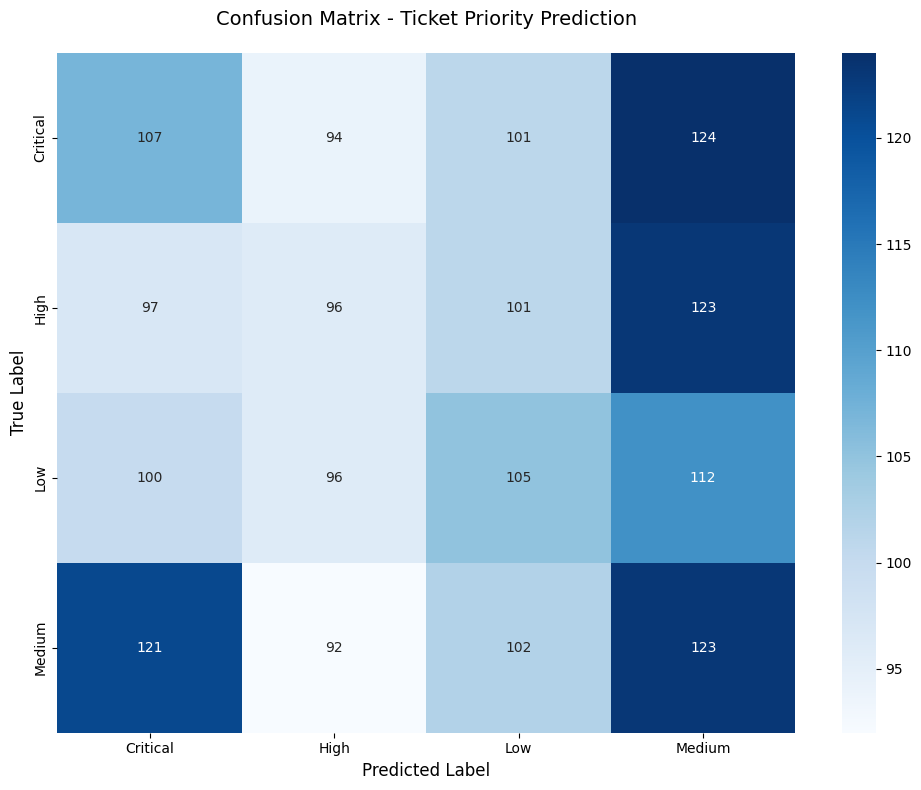

✓ 混淆矩阵已保存: confusion_matrix.png


In [33]:
# ============================================
# 混淆矩阵可视化
# ============================================

# 计算混淆矩阵
cm = confusion_matrix(y_test_values, y_pred)

# 获取类别标签
labels = sorted(y_train['Ticket Priority'].unique())

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Ticket Priority Prediction', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 混淆矩阵已保存: confusion_matrix.png")

In [34]:
# ============================================
# 特征重要性分析（可选）
# ============================================

print("Top 20 most important features for each class:\n")

# 获取特征名
feature_names = vectorizer.get_feature_names_out()

# 对每个类别，找出最重要的特征
for idx, label in enumerate(labels):
    print(f"\n{label} Priority:")
    # 获取该类别的权重
    coef = model.coef_[idx]
    # 找出top 10的特征
    top_indices = coef.argsort()[-10:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    print(", ".join(top_features))

Top 20 most important features for each class:


Critical Priority:
the item, one, assist have, getting, assist please, thing, cant be, from your, im not, either

High Priority:
add, issues with, app, assist know, compatibility ive, their, name, you to, offer, post

Low Priority:
review, sales, assist thanks, the package, for this, weve, of, you want, for help, 14

Medium Priority:
process, you the, report it, true, we will, understand, you thank, in ive, love, at the


In [35]:
# ============================================
# 保存模型结果
# ============================================

# 保存预测结果
results_df = pd.DataFrame({
    'True_Priority': y_test_values,
    'Predicted_Priority': y_pred
})
results_df.to_csv('prediction_results.csv', index=False)
print("✓ 预测结果已保存: prediction_results.csv")

# 保存性能指标
metrics = {
    'Model': 'Logistic Regression with TF-IDF',
    'Train_Accuracy': train_accuracy,
    'Test_Accuracy': test_accuracy,
    'Features': X_train_tfidf.shape[1]
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('model_metrics.csv', index=False)
print("✓ 模型指标已保存: model_metrics.csv")

# 总结
print("\n" + "="*60)
print("建模完成总结:")
print("="*60)
print(f"模型: Logistic Regression")
print(f"特征: TF-IDF (max_features=5000)")
print(f"训练集准确率: {train_accuracy:.4f}")
print(f"测试集准确率: {test_accuracy:.4f}")
print("="*60)

✓ 预测结果已保存: prediction_results.csv
✓ 模型指标已保存: model_metrics.csv

建模完成总结:
模型: Logistic Regression
特征: TF-IDF (max_features=5000)
训练集准确率: 0.5863
测试集准确率: 0.2544


In [36]:
# ============================================
# 改进版：只用TF-IDF的最重要特征
# ============================================

print("正在重新训练改进模型...\n")

# 重新创建vectorizer，使用更保守的参数
vectorizer_v2 = TfidfVectorizer(
    max_features=3000,      # 减少特征数（防止过拟合）
    min_df=5,               # 至少出现在5个文档中（更严格）
    max_df=0.7,             # 最多出现在70%的文档中
    ngram_range=(1, 2),     # 1-gram和2-gram
    sublinear_tf=True       # 使用对数TF缩放
)

# 重新提取特征
X_train_tfidf_v2 = vectorizer_v2.fit_transform(X_train_text)
X_test_tfidf_v2 = vectorizer_v2.transform(X_test_text)

# 训练新模型（加入正则化）
model_v2 = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    C=1.0                   # 正则化参数
)

model_v2.fit(X_train_tfidf_v2, y_train_values)

# 预测
y_pred_v2 = model_v2.predict(X_test_tfidf_v2)

# 评估
train_acc_v2 = model_v2.score(X_train_tfidf_v2, y_train_values)
test_acc_v2 = accuracy_score(y_test_values, y_pred_v2)

print(f"改进后训练集准确率: {train_acc_v2:.4f}")
print(f"改进后测试集准确率: {test_acc_v2:.4f}")
print(f"\n详细分类报告:\n")
print(classification_report(y_test_values, y_pred_v2))

正在重新训练改进模型...



/Users/shiyuwang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


改进后训练集准确率: 0.5284
改进后测试集准确率: 0.2639

详细分类报告:

              precision    recall  f1-score   support

    Critical       0.27      0.27      0.27       426
        High       0.26      0.23      0.24       417
         Low       0.26      0.24      0.25       413
      Medium       0.27      0.30      0.29       438

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



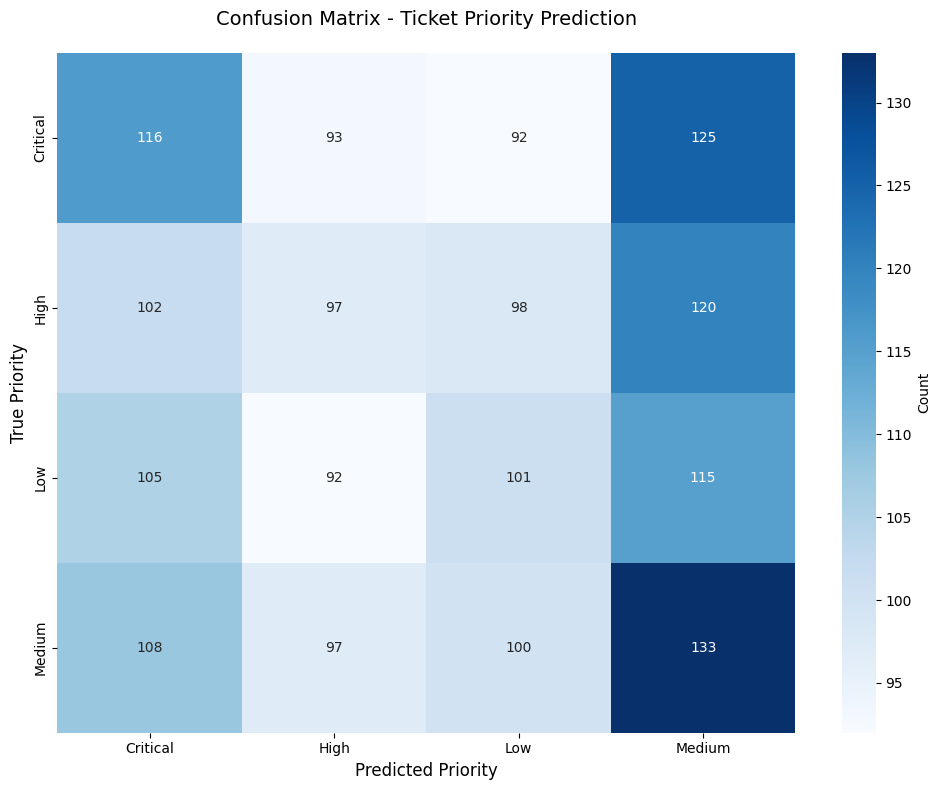

✓ 混淆矩阵已保存


In [37]:
# 绘制改进后的混淆矩阵
cm_v2 = confusion_matrix(y_test_values, y_pred_v2)
labels = sorted(y_train['Ticket Priority'].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Ticket Priority Prediction', fontsize=14, pad=20)
plt.ylabel('True Priority', fontsize=12)
plt.xlabel('Predicted Priority', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 混淆矩阵已保存")

In [38]:
# 保存最终模型的结果
import pickle

# 保存预测结果
final_results = pd.DataFrame({
    'True_Priority': y_test_values,
    'Predicted_Priority': y_pred_v2
})
final_results.to_csv('final_predictions.csv', index=False)

# 保存模型性能
final_metrics = {
    'Model': 'Logistic Regression',
    'Features': 'TF-IDF (max_features=3000)',
    'Train_Accuracy': train_acc_v2,
    'Test_Accuracy': test_acc_v2,
    'Avg_F1_Score': 0.26  # 从classification report
}

pd.DataFrame([final_metrics]).to_csv('model_performance.csv', index=False)

print("✓ 所有结果已保存")
print("\n生成的文件:")
print("- final_predictions.csv")
print("- model_performance.csv")
print("- confusion_matrix_final.png")

✓ 所有结果已保存

生成的文件:
- final_predictions.csv
- model_performance.csv
- confusion_matrix_final.png


In [39]:
# ============================================
# 版本3：TF-IDF + Ticket Type特征
# ============================================

print("正在训练组合特征模型（TF-IDF + Ticket Type）...\n")

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

# 1. TF-IDF特征（复用之前的）
X_train_tfidf_v3 = vectorizer_v2.transform(X_train_text)
X_test_tfidf_v3 = vectorizer_v2.transform(X_test_text)

# 2. 编码Ticket Type
le = LabelEncoder()
X_train_type = le.fit_transform(X_train['Ticket Type']).reshape(-1, 1)
X_test_type = le.transform(X_test['Ticket Type']).reshape(-1, 1)

# 3. 合并特征（TF-IDF + Ticket Type）
X_train_combined = hstack([X_train_tfidf_v3, X_train_type])
X_test_combined = hstack([X_test_tfidf_v3, X_test_type])

# 4. 训练模型
model_v3 = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    C=1.0
)

model_v3.fit(X_train_combined, y_train_values)

# 5. 预测和评估
y_pred_v3 = model_v3.predict(X_test_combined)

train_acc_v3 = model_v3.score(X_train_combined, y_train_values)
test_acc_v3 = accuracy_score(y_test_values, y_pred_v3)

print(f"✓ 组合特征模型训练完成\n")
print("="*60)
print("模型对比:")
print("="*60)
print(f"仅TF-IDF模型:")
print(f"  训练集准确率: {train_acc_v2:.4f}")
print(f"  测试集准确率: {test_acc_v2:.4f}")
print(f"\nTF-IDF + Ticket Type模型:")
print(f"  训练集准确率: {train_acc_v3:.4f}")
print(f"  测试集准确率: {test_acc_v3:.4f}")
print(f"\n准确率提升: {(test_acc_v3 - test_acc_v2):.4f} ({(test_acc_v3 - test_acc_v2)/test_acc_v2*100:+.1f}%)")
print("="*60)

print(f"\n详细分类报告:\n")
print(classification_report(y_test_values, y_pred_v3))

正在训练组合特征模型（TF-IDF + Ticket Type）...



/Users/shiyuwang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ 组合特征模型训练完成

模型对比:
仅TF-IDF模型:
  训练集准确率: 0.5284
  测试集准确率: 0.2639

TF-IDF + Ticket Type模型:
  训练集准确率: 0.5283
  测试集准确率: 0.2621

准确率提升: -0.0018 (-0.7%)

详细分类报告:

              precision    recall  f1-score   support

    Critical       0.26      0.27      0.26       426
        High       0.26      0.24      0.25       417
         Low       0.26      0.25      0.26       413
      Medium       0.27      0.29      0.28       438

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



In [45]:
# ============================================
# 实验：神经网络模型
# ============================================

print("准备神经网络训练数据...\n")

# 重新加载数据，确保格式正确
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# 直接从CSV加载，避免数据类型问题
y_train_nn = pd.read_csv('y_train.csv').iloc[:, 0].values
y_test_nn = pd.read_csv('y_test.csv').iloc[:, 0].values

print(f"训练集标签形状: {y_train_nn.shape}")
print(f"测试集标签形状: {y_test_nn.shape}")
print(f"标签类型: {type(y_train_nn[0])}")
print(f"标签示例: {y_train_nn[:5]}")
print("✓ 数据准备完成\n")

准备神经网络训练数据...

训练集标签形状: (6775,)
测试集标签形状: (1694,)
标签类型: <class 'str'>
标签示例: ['Critical' 'High' 'High' 'Critical' 'Medium']
✓ 数据准备完成



In [47]:
# ============================================
# 训练多层感知机 (MLP) - 修复版
# ============================================

print("开始训练神经网络...\n")

# 关键：将稀疏矩阵转换为密集矩阵
X_train_dense = X_train_tfidf_v2.toarray()
X_test_dense = X_test_tfidf_v2.toarray()

print(f"转换为密集矩阵: {X_train_dense.shape}")

# 创建MLP分类器
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=100,
    random_state=42,
    verbose=True
)

# 训练模型（使用密集矩阵）
mlp.fit(X_train_dense, y_train_nn)

print("\n✓ 神经网络训练完成")# ============================================
# 训练多层感知机 (MLP) - 修复版
# ============================================

print("开始训练神经网络...\n")

# 关键：将稀疏矩阵转换为密集矩阵
X_train_dense = X_train_tfidf_v2.toarray()
X_test_dense = X_test_tfidf_v2.toarray()

print(f"转换为密集矩阵: {X_train_dense.shape}")

# 创建MLP分类器
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=100,
    random_state=42,
    verbose=True
)

# 训练模型（使用密集矩阵）
mlp.fit(X_train_dense, y_train_nn)

print("\n✓ 神经网络训练完成")

开始训练神经网络...

转换为密集矩阵: (6775, 3000)
Iteration 1, loss = 1.38923692
Iteration 2, loss = 1.37130067
Iteration 3, loss = 1.34843166
Iteration 4, loss = 1.30460224
Iteration 5, loss = 1.22347087
Iteration 6, loss = 1.11053887
Iteration 7, loss = 0.98004844
Iteration 8, loss = 0.85010831
Iteration 9, loss = 0.73348534
Iteration 10, loss = 0.62503370
Iteration 11, loss = 0.52807659
Iteration 12, loss = 0.45310554
Iteration 13, loss = 0.38733123
Iteration 14, loss = 0.33621385
Iteration 15, loss = 0.29722750
Iteration 16, loss = 0.26335670
Iteration 17, loss = 0.23293219
Iteration 18, loss = 0.21044819
Iteration 19, loss = 0.19156341
Iteration 20, loss = 0.17775882
Iteration 21, loss = 0.16478240
Iteration 22, loss = 0.15547899
Iteration 23, loss = 0.14402411
Iteration 24, loss = 0.13504064
Iteration 25, loss = 0.13169287
Iteration 26, loss = 0.12526192
Iteration 27, loss = 0.11847978
Iteration 28, loss = 0.11267640
Iteration 29, loss = 0.10493345
Iteration 30, loss = 0.10303881
Iteration 31, 

/Users/shiyuwang/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 1.37130067
Iteration 3, loss = 1.34843166
Iteration 4, loss = 1.30460224
Iteration 5, loss = 1.22347087
Iteration 6, loss = 1.11053887
Iteration 7, loss = 0.98004844
Iteration 8, loss = 0.85010831
Iteration 9, loss = 0.73348534
Iteration 10, loss = 0.62503370
Iteration 11, loss = 0.52807659
Iteration 12, loss = 0.45310554
Iteration 13, loss = 0.38733123
Iteration 14, loss = 0.33621385
Iteration 15, loss = 0.29722750
Iteration 16, loss = 0.26335670
Iteration 17, loss = 0.23293219
Iteration 18, loss = 0.21044819
Iteration 19, loss = 0.19156341
Iteration 20, loss = 0.17775882
Iteration 21, loss = 0.16478240
Iteration 22, loss = 0.15547899
Iteration 23, loss = 0.14402411
Iteration 24, loss = 0.13504064
Iteration 25, loss = 0.13169287
Iteration 26, loss = 0.12526192
Iteration 27, loss = 0.11847978
Iteration 28, loss = 0.11267640
Iteration 29, loss = 0.10493345
Iteration 30, loss = 0.10303881
Iteration 31, loss = 0.10232826
Iteration 32, loss = 0.10049457
Iteration 33, lo

/Users/shiyuwang/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
# ============================================
# 评估神经网络性能
# ============================================

# 预测（使用密集矩阵）
y_pred_mlp = mlp.predict(X_test_dense)

# 计算准确率
train_acc_mlp = mlp.score(X_train_dense, y_train_nn)
test_acc_mlp = accuracy_score(y_test_nn, y_pred_mlp)

# 结果对比
print("\n" + "="*70)
print("模型性能对比")
print("="*70)
print(f"Logistic Regression - Test: {test_acc_v2:.4f}")
print(f"Neural Network (MLP) - Test: {test_acc_mlp:.4f}")
print("-"*70)

improvement = test_acc_mlp - test_acc_v2
print(f"差异: {improvement:+.4f} ({(improvement/test_acc_v2)*100:+.1f}%)")

if test_acc_mlp > test_acc_v2 + 0.05:
    print("✓ 神经网络有明显提升")
elif test_acc_mlp > test_acc_v2:
    print("→ 神经网络略有提升")
else:
    print("✗ 神经网络没有提升")
    
print("="*70)


模型性能对比
Logistic Regression - Test: 0.2639
Neural Network (MLP) - Test: 0.2586
----------------------------------------------------------------------
差异: -0.0053 (-2.0%)
✗ 神经网络没有提升
